In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import sys
import os

# Adiciona o diretório 'src' ao path do sistema para que possamos importar nosso módulo
sys.path.append(os.path.abspath(os.path.join('..')))
from src.data_loader import SiameseDataset

# Define os caminhos para as pastas de dados
DATA_DIR = '../data/dataset/'
T1_DIR = os.path.join(DATA_DIR, 't1')
T2_DIR = os.path.join(DATA_DIR, 't2')
MASK_DIR = os.path.join(DATA_DIR, 'mask')

In [2]:
# Cria uma instância do nosso dataset, apontando para as pastas corretas
burn_dataset = SiameseDataset(t1_dir=T1_DIR, t2_dir=T2_DIR, mask_dir=MASK_DIR)

# Cria o DataLoader para iterar sobre os dados em lotes
data_loader = DataLoader(burn_dataset, batch_size=4, shuffle=True)

print(f"Dataset carregado com sucesso! Encontradas {len(burn_dataset)} amostras.")

Dataset carregado com sucesso! Encontradas 945 amostras.


--- Iniciando Visualização da Previsão do Modelo ---
Modelo 'c:\worcap-2025-hackathon\models\best_attention_unet.pth' carregado com sucesso.


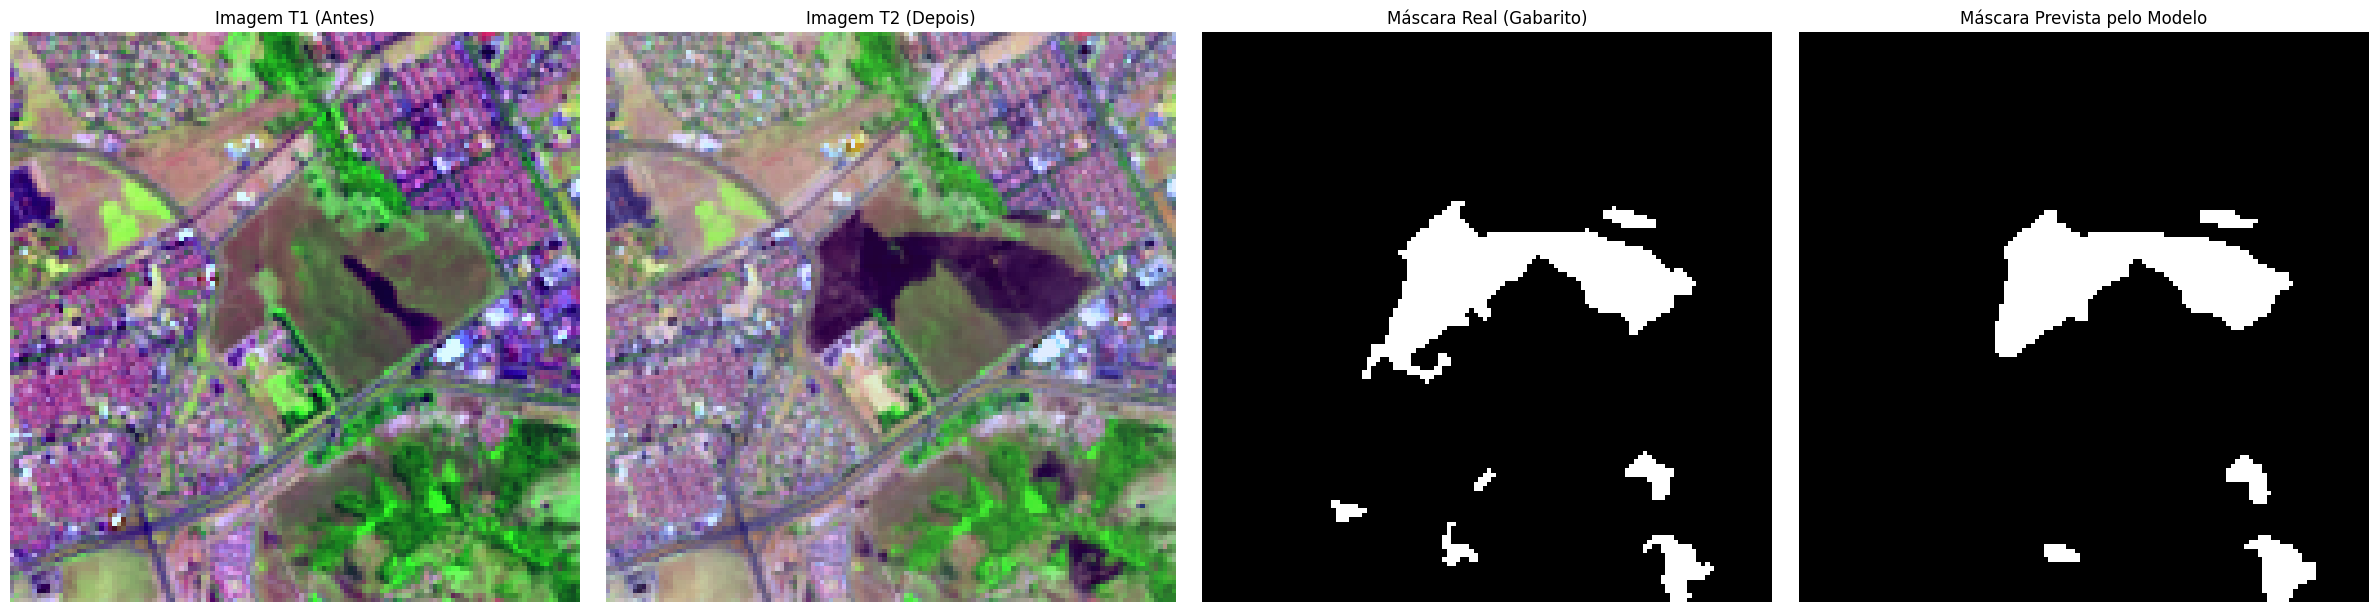

In [12]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# --- 1. SETUP ROBUSTO DE CAMINHOS ---
# Adiciona a pasta raiz do projeto ao path para garantir que as importações funcionem
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Importa nossas classes customizadas
from src.models import AttentionUNetSiamese
from src.data_loader import SiameseDataset

# Define todos os caminhos a partir da raiz do projeto, tornando-os absolutos e corretos
DATA_ROOT = os.path.join(project_root, 'data', 'processed', 'dataset')
T1_DIR = os.path.join(DATA_ROOT, 't1')
T2_DIR = os.path.join(DATA_ROOT, 't2')
MASK_DIR = os.path.join(DATA_ROOT, 'mask')
MODEL_PATH = os.path.join(project_root, 'models', 'best_attention_unet.pth')
# -----------------------------------------

print("--- Iniciando Visualização da Previsão do Modelo ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 2. Carregar o Modelo e os Dados de Validação ---
#torch.manual_seed(42)
full_dataset = SiameseDataset(t1_dir=T1_DIR, t2_dir=T2_DIR, mask_dir=MASK_DIR, augmentation=False)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_dataset = random_split(full_dataset, [train_size, val_size])

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
t1, t2, mask_real = next(iter(val_loader))

model = AttentionUNetSiamese(n_channels=9).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print(f"Modelo '{MODEL_PATH}' carregado com sucesso.")

# --- 3. Fazer a Previsão ---
t1_dev, t2_dev = t1.to(device), t2.to(device)
with torch.no_grad():
    mask_prevista_prob = model(t1_dev, t2_dev)
    mask_prevista_binaria = (mask_prevista_prob > 0.5).float()

# --- 4. Preparar Imagens para Visualização ---
# Move os tensores de volta para a CPU e converte para numpy
t1_np = t1.squeeze().numpy()
t2_np = t2.squeeze().numpy() # <-- Adicionado para T2
mask_real_np = mask_real.squeeze().numpy()
mask_prevista_np = mask_prevista_binaria.cpu().squeeze().numpy()

# Cria uma composição colorida falsa (SWIR1, NIR, RED) para T1
imagem_t1_plot = t1_np[[2, 1, 0], :, :]
imagem_t1_plot = np.moveaxis(imagem_t1_plot, 0, -1)
# Normaliza a imagem para o intervalo [0, 1] para uma exibição correta
min_val, max_val = imagem_t1_plot.min(), imagem_t1_plot.max()
if max_val > min_val:
    imagem_t1_plot = (imagem_t1_plot - min_val) / (max_val - min_val)

# Cria uma composição colorida falsa (SWIR1, NIR, RED) para T2
imagem_t2_plot = t2_np[[2, 1, 0], :, :]
imagem_t2_plot = np.moveaxis(imagem_t2_plot, 0, -1)
# Normaliza a imagem para o intervalo [0, 1] para uma exibição correta
min_val, max_val = imagem_t2_plot.min(), imagem_t2_plot.max()
if max_val > min_val:
    imagem_t2_plot = (imagem_t2_plot - min_val) / (max_val - min_val)


# --- 5. Plotar os Resultados Lado a Lado (Versão Aprimorada com 4 Imagens) ---
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

axs[0].imshow(imagem_t1_plot)
axs[0].set_title("Imagem T1 (Antes)")
axs[0].axis('off')

axs[1].imshow(imagem_t2_plot)
axs[1].set_title("Imagem T2 (Depois)")
axs[1].axis('off')

axs[2].imshow(mask_real_np, cmap='gray')
axs[2].set_title("Máscara Real (Gabarito)")
axs[2].axis('off')

axs[3].imshow(mask_prevista_np, cmap='gray')
axs[3].set_title("Máscara Prevista pelo Modelo")
axs[3].axis('off')

plt.tight_layout()
plt.show()